# BO with `ax_platform=0.4.3`

install with `pip install ax-platform==0.4.3`

https://ax.dev/

## Outline
This notebook demonstrates the use of Bayesian Optimization to find the optimal parameters for a synthetic Gaussian objective function. The key steps involved are:

1. **Define Optimization Parameters**: Set up the parameter names, bounds, and the objective function.
2. **Initialize Bayesian Optimizer**: Configure the Bayesian Optimizer Iterator with the defined parameters and settings.
3. **Run Optimization Loop**: Execute the optimization loop to iteratively suggest new parameters and observe the objective values.
4. **Store Results**: Collect the suggested parameters and observed objective values, and identify the best result.
5. **Visualize Results**: Plot the true objective function, interpolated surface, and model predictions to visualize the optimization process and results.

# Setup and Run BO

In [7]:
from BO_Iterator import BayesianOptimizerIterator, SyntheticGaussian

# Define the optimization parameters
param_names = ["a", "b"]
param_bounds = [[-1.0, 1.0], [-1.0, 1.0]]
centers = [0.2, 0.1]
sigma = 0.1
objective_function = SyntheticGaussian(centers=centers, sigma=sigma, n_samples=1)

# Initialize tracking lists and best result dictionary
suggested_params = []
observed_objective = []
best_result = {"params": None, "value": float("-inf")}

# Define BO settings
num_sobol = 20  # Number of initial Sobol samples
num_gpei = 30   # Number of GPEI trials
batch_size = 2
threshold = 0.999 # very low chance to reach with sobol
epsilon = 0.001
patience = 20
maximize = True

# Initialize the Bayesian Optimizer Iterator
bo_iterator = BayesianOptimizerIterator(
    objective_function=objective_function,     # The objective function to optimize
    param_names=param_names,                   # Names of the parameters
    param_bounds=param_bounds,                 # Bounds for the parameters
    num_sobol=num_sobol,                       # Number of initial Sobol samples
    num_gpei=num_gpei,                         # Number of GPEI trials
    batch_size=batch_size,                     # Number of trials per batch
    threshold=threshold,                       # Threshold for early stopping
    epsilon=epsilon,                           # Convergence tolerance
    patience=patience,                         # Number of iterations to wait for improvement
    maximize=maximize,                         # Whether to maximize the objective function
)

# Run the optimization loop
for output in bo_iterator:
    if "final_model" in output:
        final_model = output["final_model"]
        print("Optimization completed. Final model obtained.")
        break
    else:
        params = output
        # Collect results directly from the iterator
        z_mean, z_sem = objective_function.read([params[name] for name in param_names])
        suggested_params.append(params)
        observed_objective.append(z_mean)
        if (maximize and z_mean > best_result["value"]) or (not maximize and z_mean < best_result["value"]):
            best_result = {"params": params, "value": z_mean}

# Store and display the results
results = {
    "suggested_params": suggested_params,
    "observed_objective": observed_objective,
    "best_result": best_result,
}


[INFO 12-24 00:08:15] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 12-24 00:08:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter a. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-24 00:08:15] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter b. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 12-24 00:08:15] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='a', parameter_type=FLOAT, range=[-1.0, 1.0]), RangeParameter(name='b', parameter_type=FLOAT, range=[-1.0, 1.0])], parameter_constraints=[]).
c:\Users\Deniz\.conda

Using device: cuda


c:\Users\Deniz\.conda\envs\ds310\lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 12-24 00:08:15] ax.service.ax_client: Generated new trial 12 with parameters {'a': 0.255255, 'b': -0.514735} using model Sobol.
c:\Users\Deniz\.conda\envs\ds310\lib\site-packages\ax\modelbridge\cross_validation.py:463: UserWarning: Encountered exception in computing model fit quality: RandomModelBridge does not support prediction.
  warn("Encountered exception in computing model fit quality: " + str(e))
[INFO 12-24 00:08:15] ax.service.ax_client: Generated new trial 13 with parameters {'a': -0.802605, 'b': 0.968933} using model Sobol.
[INFO 12-24 00:08:15] ax.service.ax_client: Completed trial 12 with data: {'objective': (0.0, 0.0)}.
[INFO 12-24 00:08:15] ax.service.ax_client: Completed trial 13 with data:

Stopping early: threshold exceeded.
Optimization completed. Final model obtained.


# Printing the Best Result

In [8]:
# real peak @ 1 = (0.2, 0.1)
results['best_result']

{'params': {'a': 0.1999641617723722, 'b': 0.10000851875927497},
 'value': 0.9999999321526113}

# Visualizing of the Result

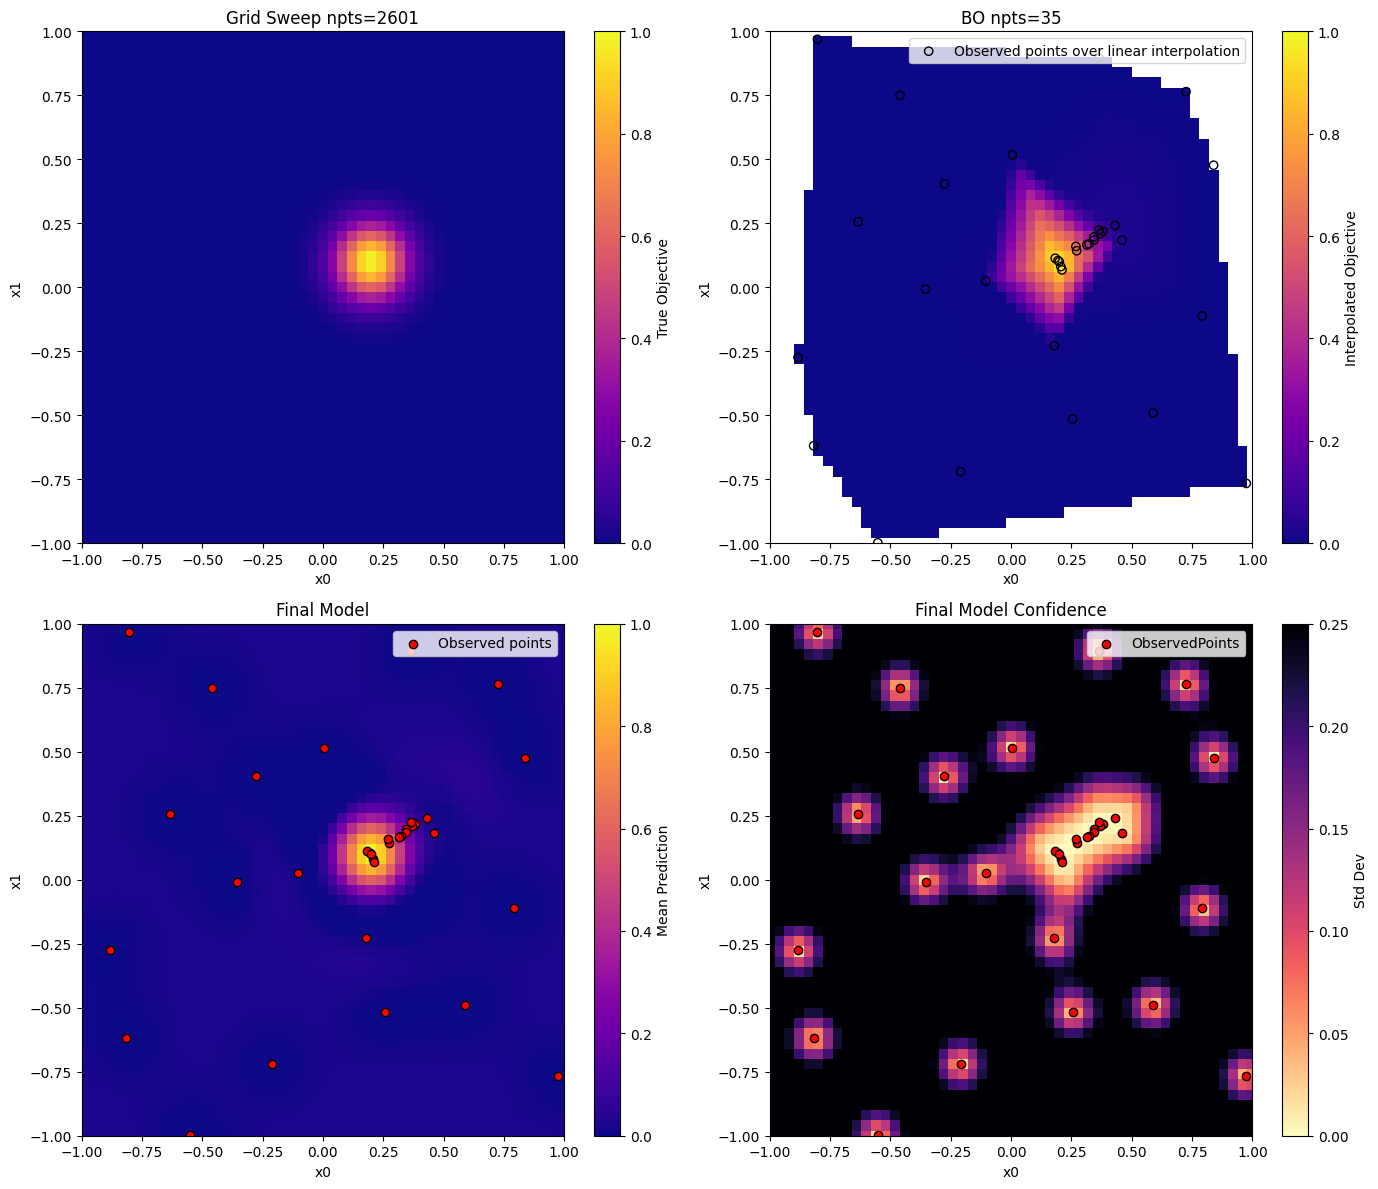

In [9]:
import numpy as np
from ax.core.observation import ObservationFeatures
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# --- Extract observed x0, x1, and objective values ---
x0_vals = [p[param_names[0]] for p in results["suggested_params"]]
x1_vals = [p[param_names[1]] for p in results["suggested_params"]]

# --- Grid Sweep: True Objective Function ---
x0 = np.linspace(-1, 1, 51)
x1 = np.linspace(-1, 1, 51)
x0_grid, x1_grid = np.meshgrid(x0, x1)
objective_grid = np.exp(-((x0_grid - centers[0]) ** 2 + (x1_grid - centers[1]) ** 2) / (2 * sigma**2))

# --- Interpolated Surface ---
x0_interp_grid, x1_interp_grid = np.meshgrid(x0, x1)
objective_interp = griddata((x0_vals, x1_vals), observed_objective, (x0_interp_grid, x1_interp_grid), method="linear")

# --- Model Predictions (Mean and Std Dev) ---
# Prepare grid for evaluation
mesh = np.column_stack([x0_grid.ravel(), x1_grid.ravel()])

# Convert grid points to Ax-compatible observation features
observation_features = [
    ObservationFeatures(parameters={param_names[0]: float(x0_val), param_names[1]: float(x1_val)})
    for x0_val, x1_val in mesh
]

# Predict using the model
mean_dict, cov_dict = final_model.predict(observation_features)

# Extract mean and covariance
mean_objective = np.array(mean_dict["objective"])
cov_objective = np.array(cov_dict["objective"]["objective"])

# Compute variance and standard deviation
var = cov_objective if cov_objective.ndim == 1 else np.diag(cov_objective)
std = np.sqrt(var)

# Reshape predictions to grid
f_mean_grid = mean_objective.reshape(x0_grid.shape)
f_std_grid = std.reshape(x0_grid.shape)

# --- Plot Results in a 2x2 Grid ---
fig, ax = plt.subplots(2, 2, figsize=(14, 12))

# Titles and labels
titles = ["Grid Sweep npts=2601", f"BO npts={len(x0_vals)}", "Final Model", "Final Model Confidence"]

cbar_labels = ["True Objective", "Interpolated Objective", "Mean Prediction", "Std Dev"]
plot_labels = [None, "Observed points over linear interpolation", "Observed points", "ObservedPoints"]
data = [objective_grid, objective_interp, f_mean_grid, f_std_grid]
cmaps = ["plasma", "plasma", "plasma", "magma_r"]
vmins = [0, 0, 0, 0]
vmaxs = [1, 1, 1, 0.25]
scatter_colors = ["none", "none", "red", "red"]


for i, ax in enumerate(ax.flat):
    c = ax.pcolormesh(x0_grid, x1_grid, data[i], shading="auto", cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i])
    if i > 0:
        ax.scatter(x0_vals, x1_vals, edgecolor="black", facecolor=scatter_colors[i], label=plot_labels[i])
        ax.legend(loc="upper right")
    ax.set_title(titles[i])
    ax.set_xlabel("x0")
    ax.set_ylabel("x1")
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    fig.colorbar(c, ax=ax, label=cbar_labels[i])

# Adjust layout and show
plt.tight_layout()
plt.show()


# Plotting convergence

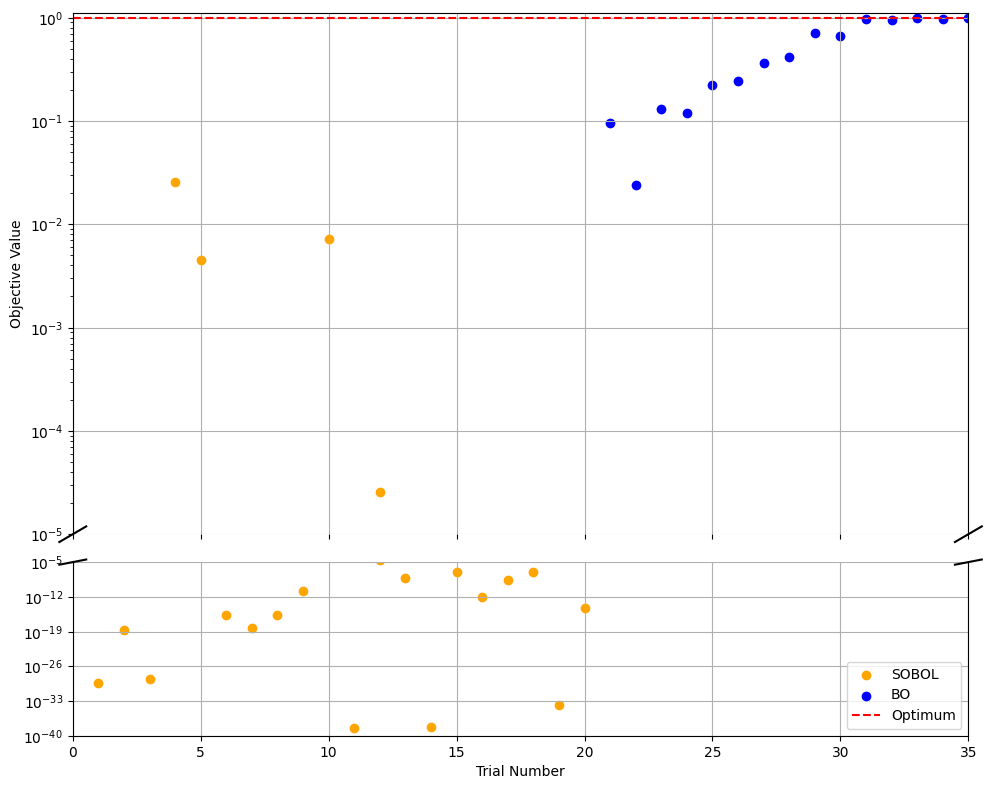

In [10]:
# Data preparation
num_initial_samples = num_sobol  # Define num_initial_samples based on num_sobol
trial_numbers = list(range(1, len(observed_objective) + 1))
random_trials = trial_numbers[:num_initial_samples]
random_objectives = observed_objective[:num_initial_samples]
bo_trials = trial_numbers[num_initial_samples:]
bo_objectives = observed_objective[num_initial_samples:]

# Create the figure and two subplots with shared x-axis
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot data
for ax in [ax1, ax2]:
    ax.scatter(random_trials, random_objectives, color='orange', label="SOBOL")
    ax.scatter(bo_trials, bo_objectives, marker='o', linestyle='-', color='b', label="BO")
    ax.axhline(y=1, color='r', linestyle='--', label="Optimum")
    ax.grid(True)
    if ax == ax2:
        ax.legend(loc="lower right")

# Set y-axis limits and scales
ax1.set_ylim(1e-5, 1.1e0)
ax2.set_ylim(1e-40, 1e-5)
ax1.set_yscale("log")
ax2.set_yscale("log")

# Hide the spines between the two y-axes
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.tick_params(labeltop=False)
ax2.tick_params(labeltop=False)

# Add diagonal lines to indicate the split
d = 0.015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# Set labels and limits
ax2.set_xlabel("Trial Number")
ax1.set_ylabel("Objective Value")
ax1.set_xlim(0, len(trial_numbers))

plt.tight_layout()
plt.show()
